# Trianing with labeled dataset

## Set up experiment

In [2]:
from azureml.core import Dataset, Datastore, Workspace, Experiment, ComputeTarget
import azureml.contrib.dataset
from azureml.contrib.dataset import FileHandlingOption, LabeledDatasetTask
from azureml.core.authentication import InteractiveLoginAuthentication
import os

In [6]:
auth = InteractiveLoginAuthentication(tenant_id="cf36141c-ddd7-45a7-b073-111f66d0b30c")
workspace = Workspace.from_config(auth=auth, path="compute/aml_config/config.json")
print("Found workspace {} at location {}".format(workspace.name, workspace.location))

Found workspace ajsdevml at location westus2


In [7]:
# create an ML experiment
import os

script_folder = './object-detection'
os.makedirs(script_folder, exist_ok=True)

exp = Experiment(workspace=workspace, name='object-detection-demo')

In [18]:
help(azureml.data.TabularDataset.to_pandas_dataframe)

Help on function _labeled_ds_to_pandas_dataframe in module azureml.contrib.dataset.labeled_dataset:

_labeled_ds_to_pandas_dataframe(self, file_handling_option=<FileHandlingOption.NONE: 2>, target_path=None, overwrite_download=False)
    Load all records from the dataset into a pandas DataFrame.
    
    :param file_handling_option: This argument only applies to TabularDatasets with the label trait, otherwise
        it is ignored. The valid options are FileHandlingOption.NONE, FileHandlingOption.DOWNLOAD (download the
        files locally), or FileHandlingOption.MOUNT (mount the files to a local path). Default is NONE.
    :type file_handling_option: :class: azureml.contrib.dataset.FileHandlingOption, optional
    :param target_path: This argument only applies to TabularDatasets with the label trait. The `target_path` is
        where the image files will be downloaded or mounted to. If `file_handling_option` is set to DOWNLOAD or
        MOUNT with no `target_path` provided, a tempo

In [4]:
# attach remote compute
compute_target = ComputeTarget(workspace=workspace, name='openhack')

In [19]:
dataset = Dataset.get_by_name(workspace, name='Roadkill-2019-11-17 23:07:07')
df = dataset.to_pandas_dataframe(file_handling_option=FileHandlingOption.MOUNT, target_path='./download/')
df.head()

KeyError: 'column'

## Create labeled dataset
### For object detection

In [11]:
# load 1 image from downlaoded path

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread(df.loc[0,'image_url'])
imgplot = plt.imshow(img)

TypeError: Object does not appear to be a 8-bit string path or a Python file-like object

In [8]:
labeled_animal.register(workspace, 'animal_labels')

{
  "source": [
    "('workspaceblobstore', '/animals_accurate_small.jsonl')"
  ],
  "definition": [
    "GetDatastoreFiles",
    "ParseJsonLines",
    "ExpressionAddColumn",
    "DropColumns",
    "DropColumns",
    "RenameColumns"
  ],
  "registration": {
    "id": "e568fa10-f765-4ec0-8dfb-57829410ff30",
    "name": "animal_labels",
    "version": 1,
    "workspace": "Workspace.create(name='mayworkspace', subscription_id='35f16a99-532a-4a47-9e93-00305f6c40f2', resource_group='maytest')"
  }
}

In [9]:
labeled_pd = labeled_animal.to_pandas_dataframe(file_handling_option=FileHandlingOption.DOWNLOAD, target_path='./download/')

In [10]:
labeled_pd

,image_url,image_details,label
0,/mnt/azmnt/code/Users/sihhu/labeleddataset-dem...,"{'format': 'png', 'width': '960px', 'height': ...","{'label': 'cat', 'topX': '0.16', 'topY': '0', ..."
1,/mnt/azmnt/code/Users/sihhu/labeleddataset-dem...,"{'format': 'jpeg', 'width': '590px', 'height':...","{'label': 'dog', 'topX': '0.1', 'topY': '0.1',..."
2,/mnt/azmnt/code/Users/sihhu/labeleddataset-dem...,"{'format': 'png', 'width': '960px', 'height': ...","{'label': 'cat', 'topX': '0.16', 'topY': '0', ..."
3,/mnt/azmnt/code/Users/sihhu/labeleddataset-dem...,"{'format': 'jpeg', 'width': '590px', 'height':...","{'label': 'dog', 'topX': '0.1', 'topY': '0.1',..."


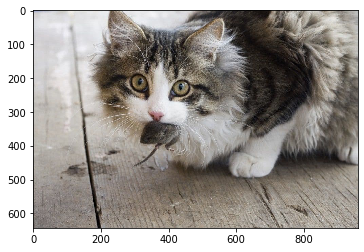

In [12]:
# load 1 image from downlaoded path

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread(labeled_pd.loc[0,'image_url'])
imgplot = plt.imshow(img)

<class 'torch.Tensor'>


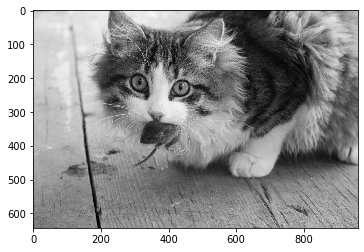

In [13]:
# load labeled_dataset2 to pytorch dataset and use methods from torchvision for image transformation

pytorch_dataset = labeled_animal._to_torchvision()

img = pytorch_dataset[0][0]
print(type(img))

import torchvision
from torchvision.transforms import functional as F
pil_image = F.to_pil_image(img)
gray_image = F.to_grayscale(pil_image, num_output_channels=3)

imgplot = plt.imshow(gray_image)

### For image classification

In [7]:
datastore = Datastore.get_default(workspace)
datapath = datastore.path('/cracks.jsonl')
labeled_dataset = Dataset._Labeled.from_json_lines(task="ImageClassification", path=datapath, validate=True)

In [8]:
labeled_dataset.register(workspace, 'cracks_labels')

{
  "source": [
    "('workspaceblobstore', '/cracks.jsonl')"
  ],
  "definition": [
    "GetDatastoreFiles",
    "ParseJsonLines",
    "ExpressionAddColumn",
    "DropColumns",
    "DropColumns",
    "RenameColumns"
  ],
  "registration": {
    "id": "4f24fd0b-324b-4d64-bdaf-0fcd90ebd2d8",
    "name": "cracks_labels",
    "version": 1,
    "workspace": "Workspace.create(name='mayworkspace', subscription_id='35f16a99-532a-4a47-9e93-00305f6c40f2', resource_group='maytest')"
  }
}

## Write training script

In [28]:
%%writefile $script_folder/train.py

import os
import torch
import torchvision
import torchvision.transforms as transforms

from azureml.core import Dataset, Run
import azureml.contrib.dataset
from azureml.contrib.dataset import FileHandlingOption, LabeledDatasetTask

run = Run.get_context()

# get input dataset by name
labeled_dataset = run.experiment.workspace.datasets['cracks_labels']
pytorch_dataset = labeled_dataset._to_torchvision()


indices = torch.randperm(len(pytorch_dataset)).tolist()
dataset_train = torch.utils.data.Subset(pytorch_dataset, indices[:40])
dataset_test = torch.utils.data.Subset(pytorch_dataset, indices[-10:])

trainloader = torch.utils.data.DataLoader(dataset_train, batch_size=4,
                                          shuffle=True, num_workers=0)

testloader = torch.utils.data.DataLoader(dataset_test, batch_size=4,
                                          shuffle=True, num_workers=0)


import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 71 * 71, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), 16 * 71 * 71)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 5 == 4:    # print every 5 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 5))
            running_loss = 0.0

print('Finished Training')
classes = trainloader.dataset.dataset.labels
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

dataiter = iter(testloader)
images, labels = dataiter.next()

import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))

net = Net()
net.load_state_dict(torch.load(PATH))

outputs = net(images)

_, predicted = torch.max(outputs, 1)

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10 test images: %d %%' % (
    100 * correct / total))
pass

Overwriting ./object-detection/train.py


## Configure Estimator

In [29]:
from azureml.core import Environment
from azureml.core.conda_dependencies import CondaDependencies

conda_env = Environment('conda-env')
conda_env.python.conda_dependencies = CondaDependencies.create(pip_indexurl='https://azuremlsdktestpypi.azureedge.net/sdk-release/master/588E708E0DF342C4A80BD954289657CF/',
                                                               pip_packages=['azureml-sdk>0.1.0.65,<0.1.1',
                                                                             'azureml-contrib-dataset',
                                                                             'scikit-learn','torch','torchvision',
                                                                             'azureml-dataprep[pandas]','matplotlib','numpy'])

In [31]:
from azureml.train.estimator import Estimator

est = Estimator(source_directory=script_folder, 
                entry_script='train.py',
                compute_target=compute_target,
                environment_definition= conda_env)

## Submit a run

In [32]:
run = exp.submit(est)

In [33]:
run.wait_for_completion(show_output=True)

RunId: object-detection_1571897753_71e4aaa1
Web View: https://ml.azure.com/experiments/object-detection/runs/object-detection_1571897753_71e4aaa1?wsid=/subscriptions/35f16a99-532a-4a47-9e93-00305f6c40f2/resourcegroups/maytest/workspaces/mayworkspace

Streaming azureml-logs/55_azureml-execution-tvmps_c2e7755b6176007c848fb591c38123cf9daab9ff05e7779d12c3d6376394217b_d.txt

2019-10-24T06:16:06Z Starting output-watcher...
Login Succeeded
Using default tag: latest
latest: Pulling from azureml/azureml_dbd9ee172b4d1fbe3a589c6ffc459411
Digest: sha256:11d0c3073c2e5af1ec4f26319a443a1015b7087c54bf88c332522154b43f5abe
Status: Image is up to date for mayworkspace8553405915.azurecr.io/azureml/azureml_dbd9ee172b4d1fbe3a589c6ffc459411:latest
e8d0a715dd2c271e1850f343b7709f3981c53a07c9364103ec35b7c76ec6d08e
2019/10/24 06:16:08 Version: 3.0.00998.0001 Branch: master Commit: 20ee96da
2019/10/24 06:16:09 sshd runtime has already been installed in the container
ssh-keygen: /azureml-envs/azureml_da0238d851c61

{'runId': 'object-detection_1571897753_71e4aaa1',
 'target': 'openhack',
 'status': 'Completed',
 'startTimeUtc': '2019-10-24T06:16:07.527933Z',
 'endTimeUtc': '2019-10-24T06:18:43.521755Z',
 'properties': {'_azureml.ComputeTargetType': 'batchai',
  'ContentSnapshotId': '44cb8d8a-7052-41b1-863a-40e1522e05ff',
  'AzureML.DerivedImageName': 'azureml/azureml_dbd9ee172b4d1fbe3a589c6ffc459411',
  'ProcessInfoFile': 'azureml-logs/process_info.json',
  'ProcessStatusFile': 'azureml-logs/process_status.json'},
 'inputDatasets': [{'dataset': {'id': 'e568fa10-f765-4ec0-8dfb-57829410ff30'}, 'consumptionDetails': {'type': 'Reference'}}, {'dataset': {'id': '4f24fd0b-324b-4d64-bdaf-0fcd90ebd2d8'}, 'consumptionDetails': {'type': 'Reference'}}, {'dataset': {'id': '136bfb9f-6de6-4b63-86c3-5b47903ec6a6'}, 'consumptionDetails': {'type': 'Reference'}}, {'dataset': {'id': 'ffccac13-3046-42bd-87c1-517c028144d4'}, 'consumptionDetails': {'type': 'Reference'}}, {'dataset': {'id': '550a2ace-6830-4565-91de-1db84